## Simple MTBD with moment-mediated mean-field interaction

In [1]:
import jax
import jax.numpy as jnp
import diffrax as dx
import equinox as eqx
import jaxopt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

jax.config.update("jax_enable_x64", True)

In [2]:
d = 5

Particle-wise birth and death rates

In [3]:
λ = 30.0 * jnp.ones(d)
λ = λ.at[0].mul(1.2)
μ = 10.0 * jnp.ones(d)

Type transition rate matrix

In [4]:
Γ = jax.scipy.linalg.toeplitz(jnp.exp(-0.1 * jnp.arange(d)))
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(0)
Γ = Γ.at[jnp.arange(d), jnp.arange(d)].set(-Γ.sum(1))

Weights on the death rate modifier.

In [5]:
W = 0.01 * jnp.ones((d, d))
# W = 0.1 * (0 * jnp.ones((d, d)) + 1 * jnp.eye(d))
# W = 0.01 * (jnp.ones((d, d)) - 0.3 * jnp.eye(d))

We model the process on the interval $[0,\tau]$.

In [6]:
τ = 1.0

We'll take the stationary state of the type transition rate matrix as the initial condition $\mathbf{r}_0$.

In [7]:
Γ_aug = jnp.vstack((Γ.T[:-1], jnp.ones(d)))
b = jnp.concatenate((jnp.zeros(d - 1), jnp.array([1])))
r0 = jnp.linalg.solve(Γ_aug, b)
r0

Array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float64)

In [8]:
@jax.jit
def f(t, v, φ):
    return (jnp.diag(λ - (μ + W @ φ.evaluate(t))) + Γ) @ v

In [9]:
@jax.jit
def 𝒯(φ):
    return dx.diffeqsolve(dx.ODETerm(f), dx.Kvaerno5(), 0.0, τ, 1e-3 * τ, r0, args=φ,
                          saveat=dx.SaveAt(dense=True),
                          stepsize_controller=dx.PIDController(rtol=1e-8, atol=1e-8),
                          max_steps=100000)

In [10]:
class FreeSolution(eqx.Module):
    def evaluate(self, t):
        A = jax.scipy.linalg.expm((jnp.diag(λ - μ) + Γ) * t)
        return A @ r0

The transcendental equation for the critical field

In [11]:
def criticality(φ):
    return (jnp.diag(λ - (μ + W @ φ)) + Γ) @ φ

In [12]:
time_grid = jnp.linspace(0.0, τ, 1000)

In [13]:
φ = FreeSolution()
converged = False
tol = 1e-5
max_iter = 1000
for i in range(max_iter):
    φ_old = φ
    φ = 𝒯(φ)
    φ_old_sample = jax.vmap(φ_old.evaluate)(time_grid)
    φ_sample = jax.vmap(φ.evaluate)(time_grid)
    error = jnp.linalg.norm((jnp.log(φ_sample) - jnp.log(φ_old_sample)) / jnp.log(φ_old_sample), ord="fro")
    assert not jnp.isnan(φ_sample).any(), φ_sample
    if error < tol:
        print(f"Converged to error {error:.2e} < {tol:.2e} after {i} iterations")
        converged = True
        break
if not converged:
    print(f"Did not converge: error = {error:.2e} after {i} iterations")

critical_solver = jaxopt.ScipyRootFinding(method="hybr", optimality_fun=criticality)
φ_critical, state = critical_solver.run(φ.evaluate(τ))
assert state.success

Converged to error 9.84e-06 < 1.00e-05 after 50 iterations


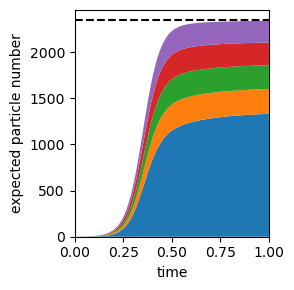

In [14]:
plt.figure(figsize=(3, 3))

plt.stackplot(time_grid, jax.vmap(φ.evaluate)(time_grid).T)
plt.axhline(φ_critical.sum(), color="black", ls="--")
plt.xlabel("time")
plt.ylabel("expected particle number")
plt.xlim(0, τ)
plt.ylim(0, None)

plt.tight_layout()
plt.savefig("output/capacity.pdf")
# plt.savefig("output/nfds.pdf")
# plt.savefig("output/pfds.pdf")
plt.show()